# Verification of the Tikhonov and Total Variation regularization implementation (2D)

This notebook is dedicated to check the implementation and the correctness of the first derivative of two classic regularization operators: Tikhonov and Total Variations. The numerical check is performed by a finite difference approximation of the first derivative.

- Import the required modules

In [5]:
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import pyrtid
from pyrtid.utils import NDArrayFloat
from pyrtid.utils.operators import gradient_ffd, hessian_cfd
from pyrtid.utils.finite_differences import finite_gradient
from pyrtid.inverse.regularization import (
    TikhonovRegularizator,
    TVRegularizator,
)
import nested_grid_plotter as ngp

In [6]:
pyrtid.utils.show_versions()

- Some configurations for the plots

In [7]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # this is required to update rcparams
plt.rcParams.update(new_rc_params)

## Case study

Let's start by defining a 2D grid with some interfaces.

In [8]:
nx: int = 15
ny: int = 26
dx: float = 7.5
dy: float = 2.6
param: NDArrayFloat = np.zeros((nx, ny), dtype=np.float64)
param[0:10, 5:15] = 5.0
param[6:14, 7:14] = 10.0
param[8:9, 2:25] = 20.0
extent = (0, nx * dx, 0, ny * dy)

- Plot the parameter structure

Text(0, 0.5, 'Y [m]')

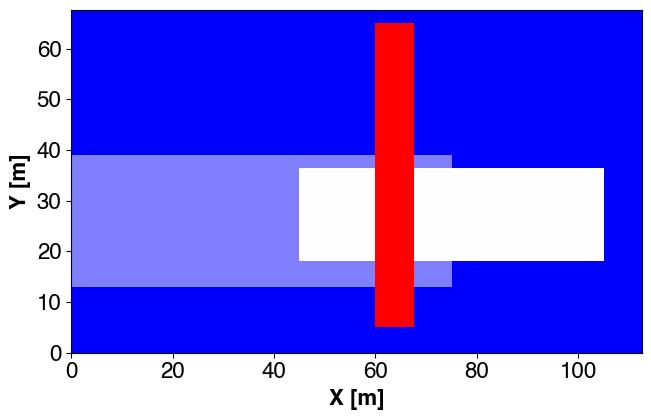

In [9]:
plt.imshow(param.T, cmap="bwr", extent=extent, origin="lower")
plt.xlabel("X [m]", fontweight="bold")
plt.ylabel("Y [m]", fontweight="bold")

- Add some noise to check all borders

In [10]:
# Add some noise with a seed
rng = np.random.default_rng(26659)
param += rng.random((nx, ny)) * 5.0

Text(0, 0.5, 'Y [m]')

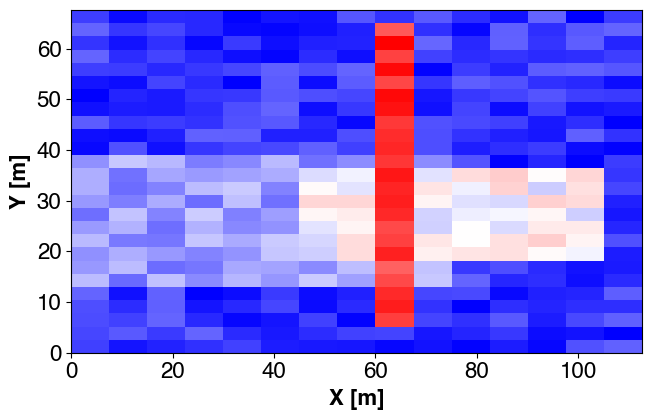

In [11]:
plt.imshow(param.T, cmap="bwr", extent=extent, origin="lower")
plt.xlabel("X [m]", fontweight="bold")
plt.ylabel("Y [m]", fontweight="bold")

## Tickonov regularisation

### Forward Difference Approximations


- Loss function computation

In [16]:
regularizator_tk = TikhonovRegularizator(dx, dy)
print(f"loss_reg_tk = {regularizator_tk.eval_loss(param)}")

regularizator_tv = TVRegularizator(dx, dy, eps=1e-20)

print(f"loss_reg_tv = {regularizator_tv.eval_loss(param)}")

loss_reg_tk = 415.80973761912236
loss_reg_tv = 28.83781328808141


- Gradient computation and verification

In [17]:
# We check the formulation by finite differences for the three cases
for regularizator in [regularizator_tk, regularizator_tv]:
    grad_reg_fd = regularizator.eval_loss_gradient(param, is_finite_differences=True)
    grad_reg_analytic = regularizator.eval_loss_gradient(param)
    np.testing.assert_allclose(grad_reg_fd, grad_reg_analytic, atol=1e-5)

In [19]:
grad_tk_fd = regularizator_tk.eval_loss_gradient(param, True)
grad_tk_an = regularizator_tk.eval_loss_gradient(param, False)
grad_tv_fd = regularizator_tv.eval_loss_gradient(param, True)
grad_tv_an = regularizator_tv.eval_loss_gradient(param, False)

- Gradient plot (isotropic vs. anisotropic / finite difference vs. analytical)

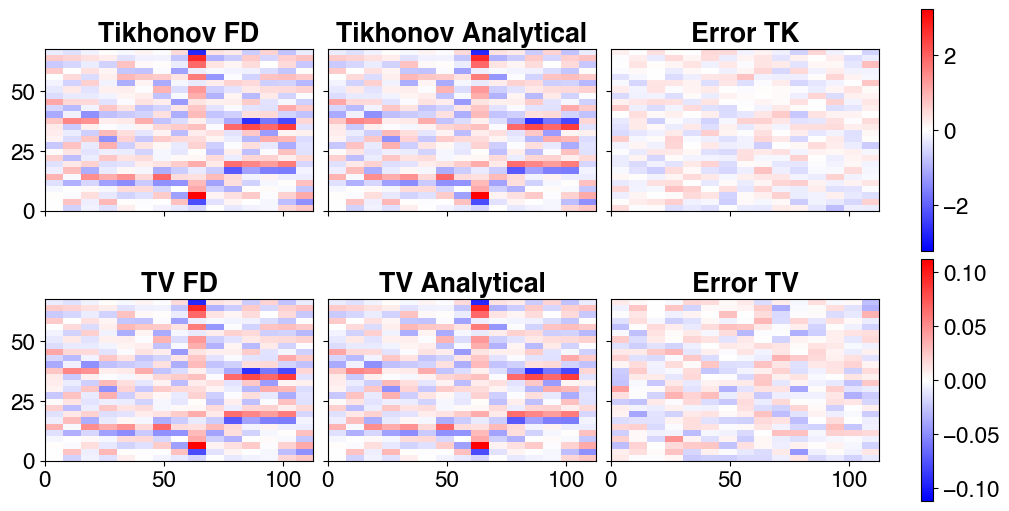

In [35]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[
                ["ax1-1", "ax1-2", "ax1-3"],
                ["ax2-1", "ax2-2", "ax2-3"],
            ],
            sharey=True,
            sharex=True,
        ),
    },
)

ngp.multi_imshow(
    plotter.axes[:3],
    plotter.fig,
    data={
        "Tikhonov FD": grad_tk_fd,
        "Tikhonov Analytical": grad_tk_an,
        "Error TK": (grad_tk_fd - grad_tk_an) * 1e8,
    },
    is_symmetric_cbar=True,
    imshow_kwargs={"extent": extent, "aspect": "equal"},
)

ngp.multi_imshow(
    plotter.axes[3:],
    plotter.fig,
    data={
        "TV FD": grad_tv_fd,
        "TV Analytical": grad_tv_an,
        "Error TV": (grad_tv_fd - grad_tv_an) * 1e8,
    },
    is_symmetric_cbar=True,
    imshow_kwargs={"extent": extent, "aspect": "equal"},
)